# QCBM and Multibasis QCBM

## Description

This notebook shows how to define and train a QCBM and a Multibasis QCBM wavefunctions.

## Defining an ansatz

Ansätze in qml-core are defined through layers. In this demo, we will use a `LineEntanglingLayerBuilder`, which creates layers of entangling gates between the first and the second qubit, the second and the third qubit, and so on. We will use an `EntanglingLayerAnsatz` which defines parameterised one-qubit rotations on each qubit, and then applies a layer of parameterised entangling gates between the qubits.

In [2]:
import torch as th
import numpy as np
from orquestra.qml.models.qcbm.layer_builders import LineEntanglingLayerBuilder
from orquestra.qml.models.qcbm.ansatze.alternating_entangling_layers import EntanglingLayerAnsatz

We are going to use the QCBM or multi-basis QCBM to generate bit strings of a given length.

In [3]:
bitstring_size = 8
n_layers = 4
entangling_layer_builder = LineEntanglingLayerBuilder(n_qubits=bitstring_size)
qcbm_ansatz = EntanglingLayerAnsatz(n_qubits=bitstring_size, n_layers=n_layers, entangling_layer_builder=entangling_layer_builder)
print(qcbm_ansatz.number_of_params)

54


In [19]:
qcbm_ansatz.parametrized_circuit

Circuit(operations=[RX(theta_0)(0), RX(theta_1)(1), RX(theta_2)(2), RX(theta_3)(3), RX(theta_4)(4), RX(theta_5)(5), RX(theta_6)(6), RX(theta_7)(7), RZ(theta_8)(0), RZ(theta_9)(1), RZ(theta_10)(2), RZ(theta_11)(3), RZ(theta_12)(4), RZ(theta_13)(5), RZ(theta_14)(6), RZ(theta_15)(7), XX(theta_16)(0,1), XX(theta_17)(1,2), XX(theta_18)(2,3), XX(theta_19)(3,4), XX(theta_20)(4,5), XX(theta_21)(5,6), XX(theta_22)(6,7), RX(theta_23)(0), RX(theta_24)(1), RX(theta_25)(2), RX(theta_26)(3), RX(theta_27)(4), RX(theta_28)(5), RX(theta_29)(6), RX(theta_30)(7), RZ(theta_31)(0), RZ(theta_32)(1), RZ(theta_33)(2), RZ(theta_34)(3), RZ(theta_35)(4), RZ(theta_36)(5), RZ(theta_37)(6), RZ(theta_38)(7), RX(theta_39)(0), RX(theta_40)(1), RX(theta_41)(2), RX(theta_42)(3), RX(theta_43)(4), RX(theta_44)(5), RX(theta_45)(6), RX(theta_46)(7), XX(theta_47)(0,1), XX(theta_48)(1,2), XX(theta_49)(2,3), XX(theta_50)(3,4), XX(theta_51)(4,5), XX(theta_52)(5,6), XX(theta_53)(6,7)], n_qubits=8)

## Defining the trainable QCBM wavefunction

Now, with the given parameterised ansatz we are able to define a trainable QCBM, which is just a generative model equivalent to any other generative model in `orquestra.qml`.

In principle, trainable QCBM wavefunctions can be optimised with gradient-free optimisers (they can be local or global optimisers). Further, these trainable QCBM wavefunctions use Zapata's parameterised circuits, so we must specify a particular quantum backend or simulator to run the circuit on. For simplicity, we will use a `ScipyOptimizer` to optimise the trainable QCBM wavefunction, and we are using the `QulacsSimulator` as the backend.

In [4]:
from orquestra.qml.models.qcbm import WavefunctionQCBM
from orquestra.integrations.qulacs.simulator import QulacsSimulator
from orquestra.opt.optimizers.scipy_optimizer import ScipyOptimizer

# We use just one iteration of the scipy optimizer. If we want more iterations, we will specify those as "epochs" when training.
# In other words, the optimizer will not be called directly to train the PQC: it will be called under the hood.
optimizer = ScipyOptimizer(method="Powell", options={"maxiter": 1})
qcbm = WavefunctionQCBM(ansatz=qcbm_ansatz, optimizer=optimizer, backend=QulacsSimulator(), choices=(0, 1), use_efficient_training=False)

Note that we have used `use_efficient_training=False`. QCBMs can train efficiently, meaning that it will have access to a target probability vector whose length is equal to the size of the bit string space ($2^{\text{bitstring\_size}}$). If no efficient training is used, it means that under the hood, a probability distribution is built out of an incomplete target probability vector (usually, bitstrings with target probability equal to zero will not be included in many data loaders). Here, we will not use efficient training–we will do this later!

### Dataset

Let us build a cardinality dataset, as an example of a dataset.

In [5]:
from orquestra.qml.data_loaders import CardinalityDataLoader

dataloader = CardinalityDataLoader(n_qubits=bitstring_size, cardinality=bitstring_size//2, batch_size=-1).shuffle(seed=1234)

Let's see how this dataset looks like by loading it into a `BitstringDistribution` object.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


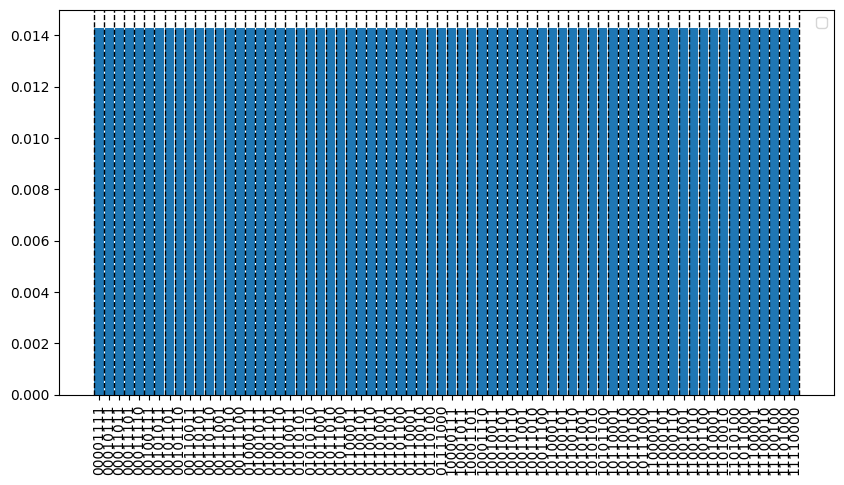

In [6]:
from orquestra.qml.api import BitstringDistribution

batch = next(iter(dataloader.load_data())).convert_to_numpy()
bitstring_distribution = BitstringDistribution(data=batch.data, probs=batch.probs)
if bitstring_distribution.n_features<=8:
    bitstring_distribution.plot()

## Training the QCBM wavefunction

Now we are ready to define a trainer and train the QCBM wavefunction.

In [25]:
from orquestra.qml.trainers import SimpleTrainer

trainer = SimpleTrainer()
result = trainer.train(qcbm, dataloader, n_epochs=40)

Epoch 40 / 40: 100%|██████████| 1/1 [00:01<00:00,  1.27s/steps, opt_value=4.8145E+00, nfev=5.7000E+02]


In [26]:
new  = qcbm.generate(10)


In [27]:
new

array([[0, 1, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 1, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0],
       [1, 0, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 1, 1],
       [1, 0, 1, 1, 1, 0, 0, 0]])

We can see the loss function value after each iteration of the training.

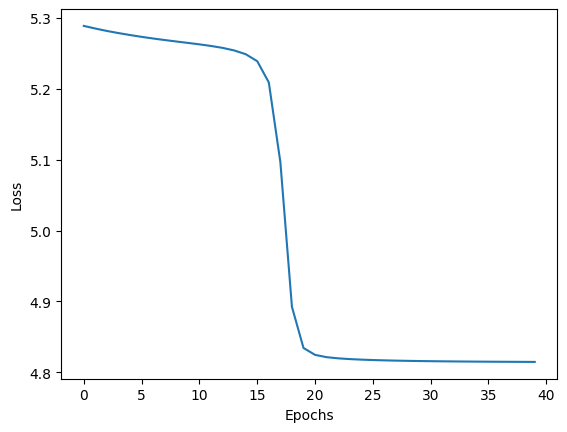

In [28]:
import matplotlib.pyplot as plt

plt.plot(result["history"]["opt_value"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Generating samples from the QCBM wavefunction

We can now generate samples from the trained QCBM wavefunction. In particular, we will also generate many samples to approximate the probability distribution of the QCBM wavefunction after training and compare it with the original probability distribution.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


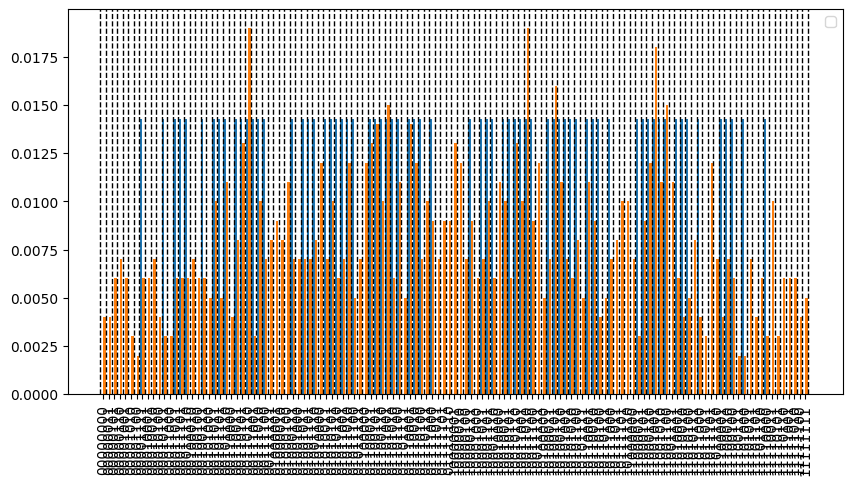

In [29]:
new_samples = qcbm.generate(n_samples=1000, random_seed=98752)
new_bitstring_distribution = BitstringDistribution.frequency_distribution(new_samples)
new_data, new_probs = new_bitstring_distribution.to_tensors()
other_bitstrings = [(new_data, new_probs)]
# Specify a cutoff so that bitstrings with very low probability are not shown
bitstring_distribution.plot(other_bitstrings=other_bitstrings, cutoff = 0.001)

### Efficient training for the QCBM wavefunction

Now, let us try to train the QCBM wavefunction efficiently. We will use the same dataset as before, but this time we will provide the QCBM with a complete target probability vector–**needed for efficient training**.

In [48]:
bitstring_distribution.backfill()
bitstring_distribution.sort()
data, target_probs = bitstring_distribution.to_tensors()
target_probs

array([0., 0., 0., ..., 0., 0., 0.])

We must create a dataloader with this target probability vector.

In [10]:
from orquestra.qml.data_loaders import new_data_loader
import numpy as np

# We don't care about the data:
efficient_dataloader = new_data_loader(np.empty((target_probs.size, 1)), probs=target_probs, batch_size=-1)

Epoch 40 / 40: 100%|██████████| 1/1 [00:00<00:00,  3.00steps/s, opt_value=3.3908E+00, nfev=4.9000E+02]


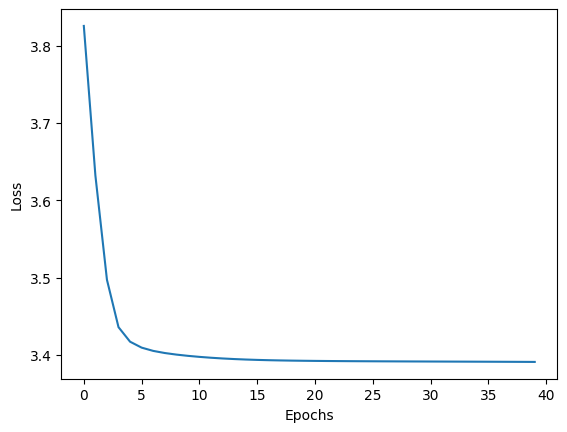

In [11]:
qcbm = WavefunctionQCBM(ansatz=qcbm_ansatz, optimizer=optimizer, backend=QulacsSimulator(), choices=(0, 1), use_efficient_training=True)
trainer = SimpleTrainer()
result = trainer.train(qcbm, efficient_dataloader, n_epochs=40)

plt.plot(result["history"]["opt_value"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Let's plot the distribution again:

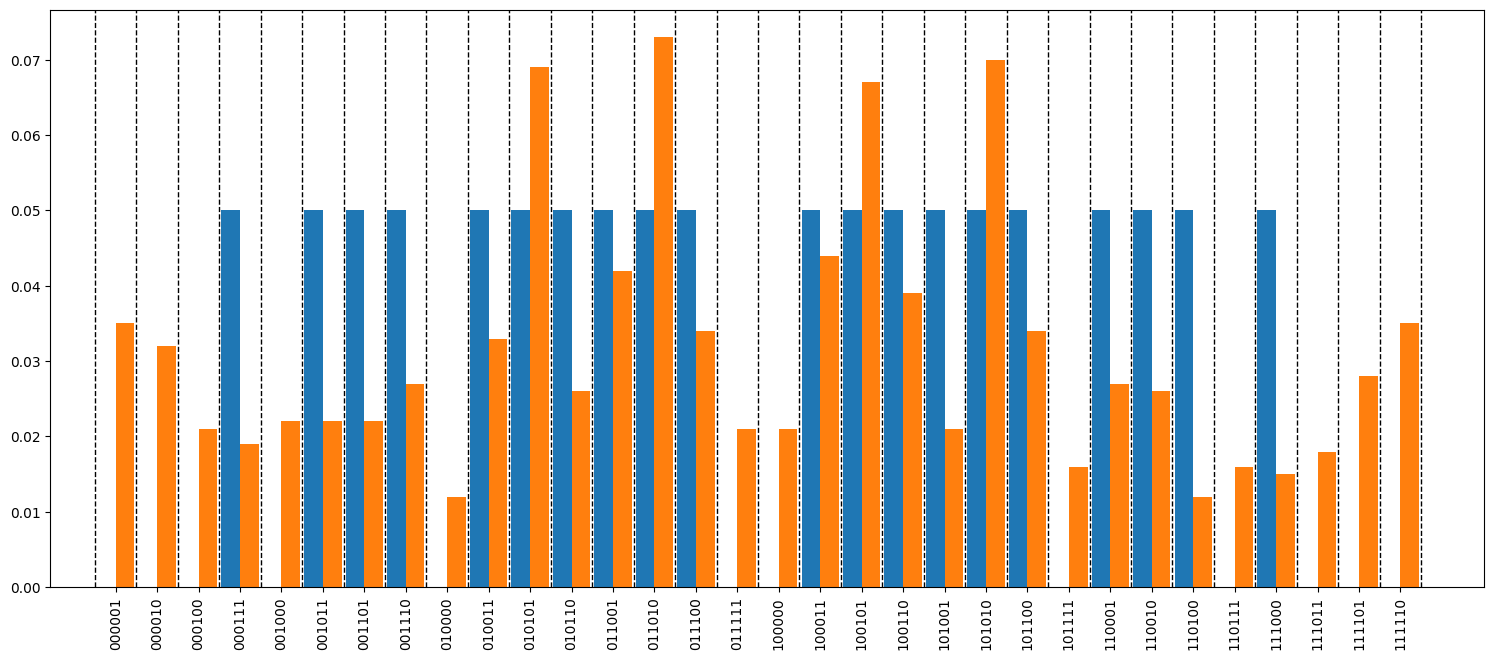

In [12]:
new_samples = qcbm.generate(n_samples=1000, random_seed=98752)
new_bitstring_distribution = BitstringDistribution.frequency_distribution(new_samples)
new_data, new_probs = new_bitstring_distribution.to_tensors()
other_bitstrings = [(new_data, new_probs)]
# Specify a cutoff so that bitstrings with very low probability are not shown
bitstring_distribution.plot(other_bitstrings=other_bitstrings, cutoff = 0.001)

## Defining the trainable Multibasis QCBM wavefunction

Now, we will define a trainable Multibasis QCBM wavefunction. We will use the same dataset as before, and we will be using an extra basis of measurement. This means that we will need half the number of qubits to represent the same bit string space.

In [7]:
from orquestra.qml.models.qcbm import MultiBasisWavefunctionQCBM
from orquestra.quantum.circuits import X, create_layer_of_gates

entangling_layer_builder = LineEntanglingLayerBuilder(n_qubits=bitstring_size//2)
multiqcbm_ansatz = EntanglingLayerAnsatz(n_qubits=bitstring_size//2, n_layers=5, entangling_layer_builder=entangling_layer_builder)
# We create a circuit that rotates the basis of the qubits at the end of the circuit
rotate_basis_circuit = create_layer_of_gates(number_of_qubits=bitstring_size//2, gate_factory=X)
multiqcbm = MultiBasisWavefunctionQCBM(ansatz=multiqcbm_ansatz, optimizer=optimizer, backend=QulacsSimulator(), choices=(0, 1), use_efficient_training=False, train_basis=False, basis_rotations=rotate_basis_circuit)

You see that we have selected `train_basis=False`, which means that the rotation circuit will not be trained (it can't be trained anyways because it does not have any parameters).

Epoch 1 / 40:   0%|          | 0/1 [00:00<?, ?steps/s, opt_value=4.0346E+00, opt_params=[ 1.6174 -0.5253  0.2769 -0.6361  0.0123  1.8049 -0.656   1.2005  0.2468
 -0.3895  0.2165 -1.4083  0.7161 -0.3721 -0.9244 -0.3819 -0.1325  0.8279
Epoch 1 / 40: 100%|██████████| 1/1 [00:00<00:00,  8.54steps/s, opt_value=4.0346E+00, opt_params=[ 1.6174 -0.5253  0.2769 -0.6361  0.0123  1.8049 -0.656   1.2005  0.2468
 -0.3895  0.2165 -1.4083  0.7161 -0.3721 -0.9244 -0.3819 -0.1325  0.8279
Epoch 1 / 40: 100%|██████████| 1/1 [00:00<00:00,  8.54steps/s, opt_value=4.0346E+00, opt_params=[ 1.6174 -0.5253  0.2769 -0.6361  0.0123  1.8049 -0.656   1.2005  0.2468
 -0.3895  0.2165 -1.4083  0.7161 -0.3721 -0.9244 -0.3819 -0.1325  0.8279
Epoch 1 / 40: 100%|██████████| 1/1 [00:00<00:00,  8.47steps/s, opt_value=4.0346E+00, opt_params=[ 1.6174 -0.5253  0.2769 -0.6361  0.0123  1.8049 -0.656   1.2005  0.2468
 -0.3895  0.2165 -1.4083  0.7161 -0.3721 -0.9244 -0.3819 -0.1325  0.8279
  0.4382  0.0494 -0.2091 -0.1748  0.922 

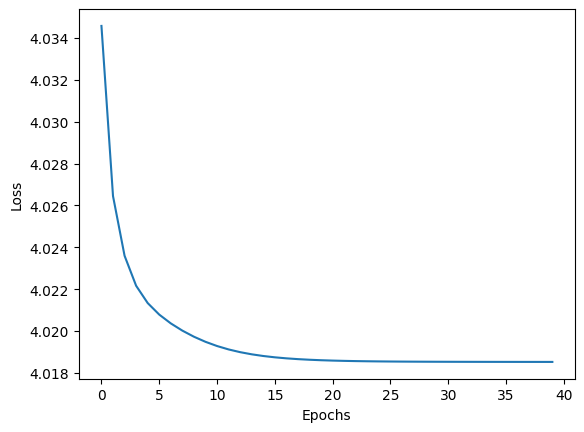

In [14]:
trainer = SimpleTrainer()
result = trainer.train(multiqcbm, dataloader, n_epochs=40)
plt.plot(result["history"]["opt_value"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Note that results are a bit worse (probably because we are using less variational parameters).

Finally, we plot the distribution again:

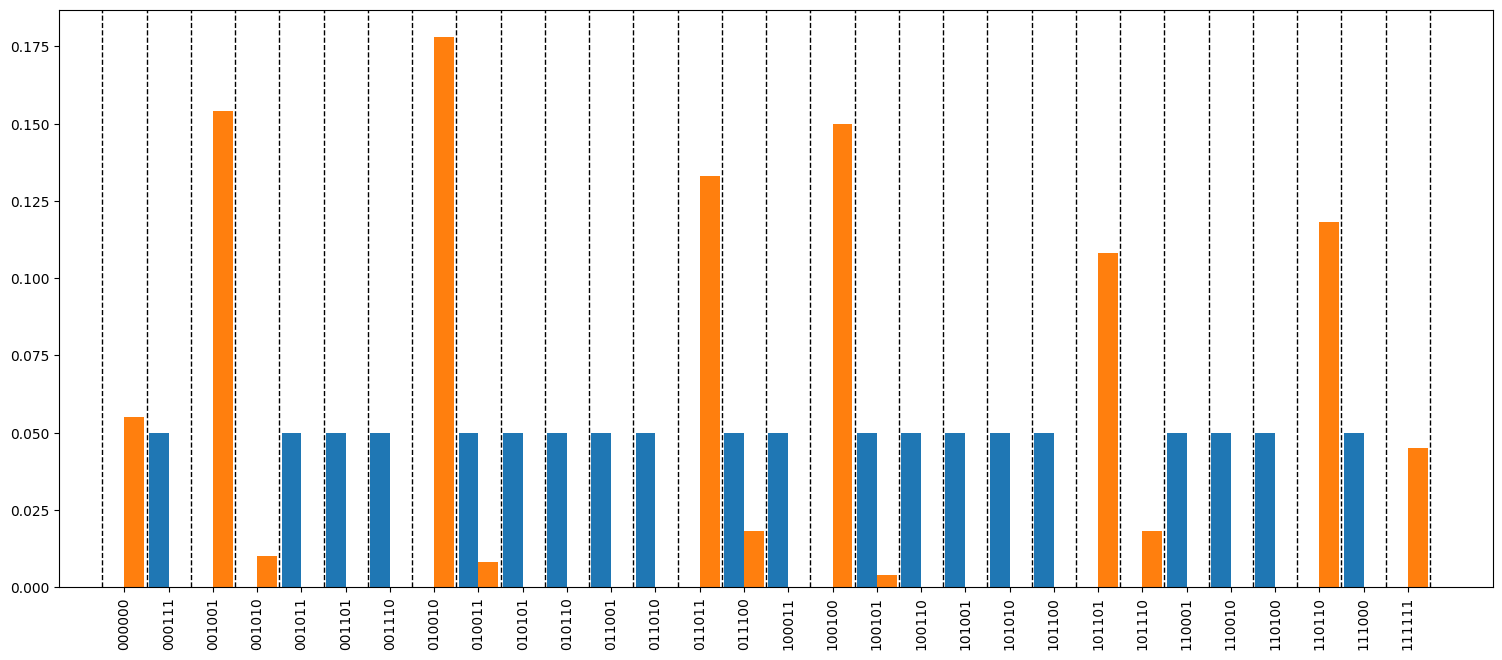

In [15]:
new_samples = multiqcbm.generate(n_samples=1000, random_seed=98752)
new_bitstring_distribution = BitstringDistribution.frequency_distribution(new_samples)
new_data, new_probs = new_bitstring_distribution.to_tensors()
other_bitstrings = [(new_data, new_probs)]
# Specify a cutoff so that bitstrings with very low probability are not shown
bitstring_distribution.plot(other_bitstrings=other_bitstrings, cutoff = 0.001)

### Efficient training for the Multibasis QCBM wavefunction

Now we load the complete probability vector to train the Multibasis QCBM wavefunction efficiently. However, let's try to give the same number of variational parameters to the Multibasis QCBM wavefunction as we did to the QCBM wavefunction.

In [16]:
print(qcbm_ansatz.number_of_params, multiqcbm_ansatz.number_of_params)

52 25


In [17]:
entangling_layer_builder = LineEntanglingLayerBuilder(n_qubits=bitstring_size//2)
multiqcbm_ansatz = EntanglingLayerAnsatz(n_qubits=bitstring_size//2, n_layers=12, entangling_layer_builder=entangling_layer_builder)
print(multiqcbm_ansatz.number_of_params)

51


Epoch 1 / 40:   0%|          | 0/1 [00:00<?, ?steps/s, opt_value=4.0402E+00, opt_params=[-0.6276  0.4145 -0.6221  0.61   -0.147   1.1625 -0.8649 -0.5902 -0.1489
  1.0915 -1.2302  1.2991  1.5155 -1.2837  1.528   0.0917  1.1004  1.2221
  0.4106 -1.3602  1.7876  0.9335 -0.1778 -1.6695 -1.6074 -0.8013  1.3104
  0.4391 -0.28    1.0654 -1.0165  1.0446 -0.8439  0.181   0.5885 -1.2871
  0.8051  1.0823  1.3215  0.1784  0.0963 -1.0053  1.2423 -0.1826  0.0235
Epoch 1 / 40: 100%|██████████| 1/1 [00:00<00:00,  2.62steps/s, opt_value=4.0402E+00, opt_params=[-0.6276  0.4145 -0.6221  0.61   -0.147   1.1625 -0.8649 -0.5902 -0.1489
  1.0915 -1.2302  1.2991  1.5155 -1.2837  1.528   0.0917  1.1004  1.2221
  0.4106 -1.3602  1.7876  0.9335 -0.1778 -1.6695 -1.6074 -0.8013  1.3104
  0.4391 -0.28    1.0654 -1.0165  1.0446 -0.8439  0.181   0.5885 -1.2871
  0.8051  1.0823  1.3215  0.1784  0.0963 -1.0053  1.2423 -0.1826  0.0235
Epoch 1 / 40: 100%|██████████| 1/1 [00:00<00:00,  2.62steps/s, opt_value=4.0402E+00, o

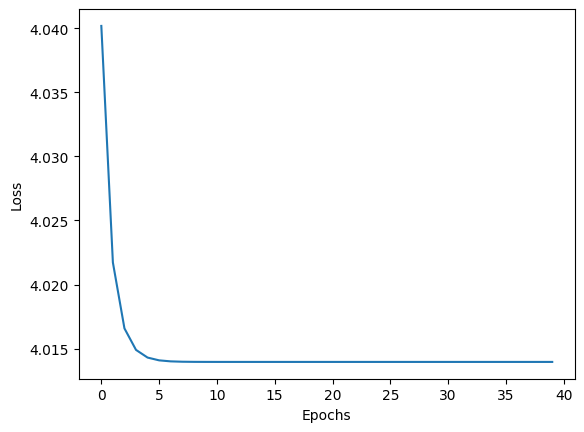

In [18]:
multiqcbm = MultiBasisWavefunctionQCBM(ansatz=multiqcbm_ansatz, optimizer=optimizer, backend=QulacsSimulator(), choices=(0, 1), use_efficient_training=True, train_basis=False, basis_rotations=rotate_basis_circuit)
trainer = SimpleTrainer()
result = trainer.train(multiqcbm, efficient_dataloader, n_epochs=40)
plt.plot(result["history"]["opt_value"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

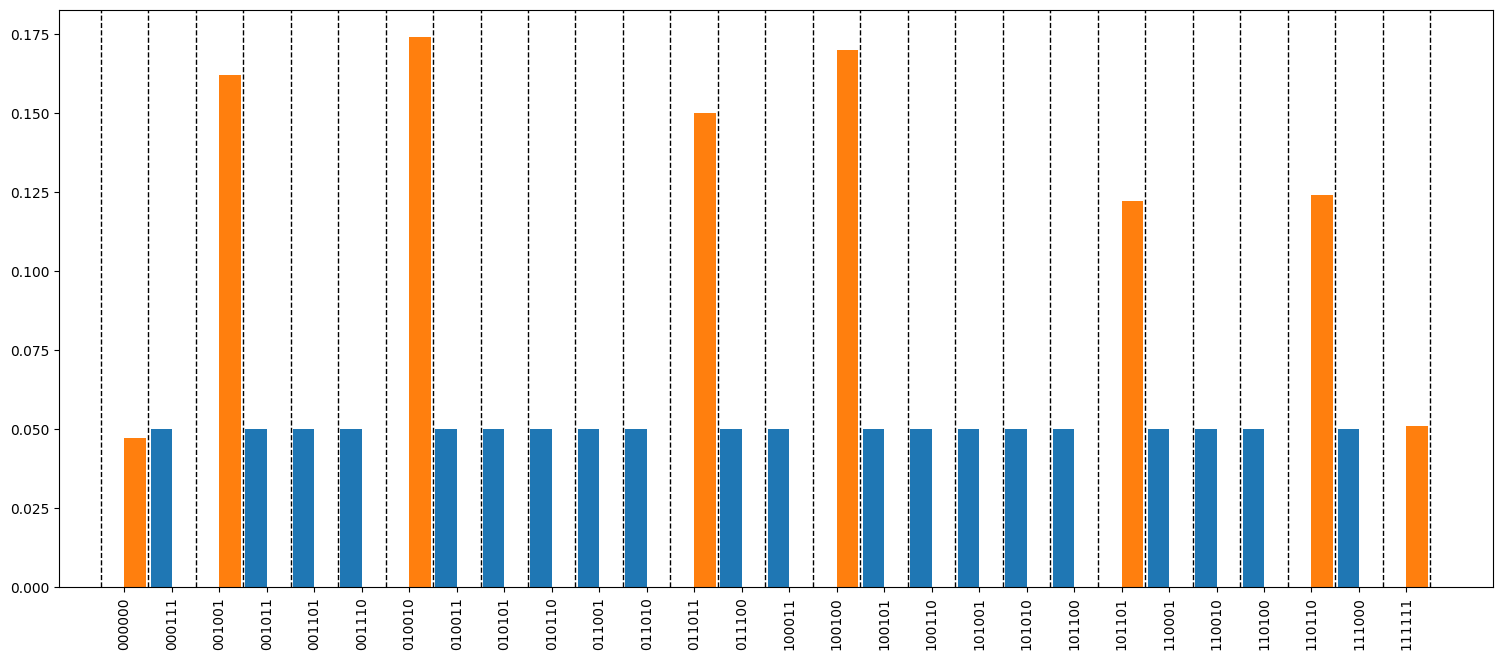

In [19]:
new_samples = multiqcbm.generate(n_samples=1000, random_seed=98752)
new_bitstring_distribution = BitstringDistribution.frequency_distribution(new_samples)
new_data, new_probs = new_bitstring_distribution.to_tensors()
other_bitstrings = [(new_data, new_probs)]
# Specify a cutoff so that bitstrings with very low probability are not shown
bitstring_distribution.plot(other_bitstrings=other_bitstrings, cutoff = 0.001)